# Installing Packages

In [1]:
using Dates, Distributions, Roots, DelimitedFiles,CSV,DataFrames, Lux, FinancialToolbox, Random, Plots, Statistics, Flux, DiffEqFlux, StochasticDiffEq, DiffEqBase.EnsembleAnalysis, DifferentialEquations, Distributions;

# Generating Constant Elasticity of Variance Stock Paths
$dS_t = rS_tdt + \sigma S_t^\alpha dW_t$ <br>
$S_0 = 100$ <br>
$r = 8\%$ <br>
$\sigma = 200\%$ <br>
$\alpha \in [0,1]$, So the stock model produces behaviour consistent with the leverage effect.  <br>
$\alpha = 0.5$, a square root process - similar to CIR without mean reversion, has an analytical solution for stock prices. <br>

In [2]:
Random.seed!(1)
S₀ = Float32[100];
r = 0.08; 
σ = 2;  
α = 0.5; 
tspan = (0.0,1.0); 
n = (0.0,1.0); # The timespan for the problem.
datasize = 100;
tsteps = range(tspan[1], tspan[2], length = datasize);
dt = tsteps[2]; 
CEV_drift(S,p,t) = r*S; # The drift function in the SDE.
CEV_diffusion(S,p,t) = σ*(S.^α); # The noise function in the SDE.
CEV = SDEProblem(CEV_drift,CEV_diffusion,S₀,tspan); # GBM.  

Solution = solve(CEV, EM(),dt = dt); # Trajectories is the number of simulations being run. EM() doesn't do a good job, or can use the analytical solution. We use a fast adaptive method which is very close to the analytical. Compare this to EM in dissertation. 
Stock_path = Solution[1,:]
plot(Solution,title="CEV Stock Path",label = "CEV Stock Price",xlabel = "Time",ylabel = "Stock Price");

# Initialising the Neural SDE
We setup the neural SDE by replacing the diffusion component of the CEV model with a neural network. We use the same drift condition as the CEV model to ensure no-arbitrage. As you can see by the plot, we need to train the neural network to get a better approximation. We also generate a stock path under the neural SDE, to show this point that we still need to conduct training to get a better approximation. 

In [3]:
gridsize = 200;
Func(x) = σ*x.^α;
X_Training = collect(range(0,stop=100,length=gridsize));
Y_Training = Func.(X_Training);

gridsize1 = 20;
X_Testing = collect(range(0,stop=100,length=gridsize1));
Y_Testing = Func.(X_Testing)

data = []
for i in 1:length(X_Training)
    push!(data, ([X_Training[i]], Y_Training[i]))
end



Q = 16
model = Flux.Chain(Flux.Dense(1,Q,elu),Flux.Dense(Q,1,softplus));  


plt1 = plot(X_Testing ,[Y_Testing  model(X_Testing')'],title="Diffusion Coefficient Before Training",label=["CEV Diffusion Coefficient" "Neural Network"], xlabel = "S",ylabel = "Diffusion Coefficient") # before training

NSDE_diffusion_Before(S,p,t) = model(S);
NSDE_Before = SDEProblem(CEV_drift,NSDE_diffusion_Before,S₀,tspan);  
Solution_Before = solve(NSDE_Before, EM(),dt = dt); 
before_data = model(X_Testing')'[:,1]
plot(Solution,title="CEV Stock Path",label = "CEV Stock Price")
plt2 = plot!(Solution_Before,title="Stock Paths",label = "Neural SDE Stock Price Before Training", xlabel = "Time",ylabel = "Stock Price")

plt = plot(plt1, plt2, layout = (2, 1));

# Training the Neural Network
Using the training data previously specified, we train the neural network approximating the diffusion coefficent. As can be seen by the plot, the neural network provides a good approximation. 

In [4]:
# Vanilla Call Price Function. 

function call_pricer(stock_price,K)
    A = stock_price-ones(size(stock_price))*K
    B = maximum([A zeros(size(A))],dims=2)
    return exp(-r*tspan[2])*mean(B)
end 

ensemble_prob_before = EnsembleProblem(NSDE_Before);
ensemble_sol_before = solve(ensemble_prob_before, EM(),dt = dt, trajectories = 10000); # We generate data from the average of 10,000 runs of the SDE.

stock_price_before= ensemble_sol_before[1,end,:];

K = range(80, 120, length = 21)
K1 = 100 ./ range(80, 120, length = 21)
K1 = K1[:,1]
log_moneyness = log.(K1)
NSDE_Price_before = zeros(1,length(K))

for i in 1:length(K)
    NSDE_Price_before[i] = call_pricer(stock_price_before,K[i])
end 


plt9 = scatter(K,NSDE_Price_before',title="Call Prices",label = "Neural SDE Call Price Before Training",xlabel = "Strike",ylabel = "Price");


In [5]:
t1 = now()
loss(x, y) = Flux.mse(model(x), y)
opt = Adam()
ps = Flux.params(model)

for epoch in 1:50000
    Flux.train!(loss, ps, data, opt);
    #display(epoch)
end

In [6]:
t2 = now()
println(t2-t1)

100375 milliseconds


In [7]:
after_data = model(X_Testing')'[:,1]
plt3 = plot(X_Testing ,[Y_Testing  model(X_Testing')'],title="Diffusion Coefficient After Training",label=["CEV Diffusion Coefficient" "Neural Network"], xlabel = "S",ylabel = "Diffusion Coefficient") # before training

plt4 = plot(plt1, plt3, layout = (2, 1));

# Generating Stock Paths from our Neural SDE
Now that we have shown that our neural network representing the diffusion coefficient provides a good approximation, we generate stock paths from the neural SDE and compare it to the stock paths produced by CEV.

In [8]:
NSDE_diffusion(S,p,t) = model(S);
NSDE = SDEProblem(CEV_drift,NSDE_diffusion,S₀,tspan); 

NSDE_Solution = solve(NSDE,EM(),dt = dt); # Trajectories is the number of simulations being run. EM() doesn't do a good job, or can use the analytical solution. We use a fast adaptive method which is very close to the analytical. Compare this to EM in dissertation. 
NSDE_Stock_path = NSDE_Solution[1,:]

plot(Solution,title="CEV Stock Path",label = "CEV Stock Price")
plot!(NSDE_Solution,title="Stock Paths After Training",label = "Neural SDE Stock Price After Training", xlabel = "Time",ylabel = "Stock Price");

# CEV Option Pricning Formula

In [9]:
K = range(80, 120, length = 21)
function C(S0, r, σ, T, K, α)
k = 2*r./(σ.^2 * (1 - α) * (exp(2*r * (1 - α) * T) - 1))
x = k * S0.^(2 * (1 - α)) * exp(2*r * (1 - α) * T)
x = x[1]
y = k * K.^(2 * (1 - α))
z = 2 + 1 / (1 - α)
non_central_chi_square = NoncentralChisq(z, x)
X_x = cdf(non_central_chi_square, y)
X_y = cdf(NoncentralChisq(z - 2, y), x)
return S0 * (1 .- X_x) .- K * exp(-r * T) * X_y
end



CEV_Price = zeros(1,length(K)) 

for i in 1:length(K)
    A = C(S₀, r, σ, tspan[2], K[i], α)
    CEV_Price[i] = A[1]
end

CEV_Price = CEV_Price[1,:]

21-element Vector{Float64}:
 26.766042769442592
 25.09022963287636
 23.449767255491352
 21.84910693409627
 20.292702357098435
 18.784913544575815
 17.32990887787355
 15.93156919921887
 14.59339788295761
 13.318440472156666
 12.109216966061041
 10.96766917732075
  9.895124804216579
  8.892279037756424
  7.959193701337924
  7.09531315175262
  6.299495496517196
  5.570057135262807
  4.9048282319707255
  4.3012164782663405
  3.7562764130431923

# Generating Multiple Trajectories
We generate 10 000 samples, which we will use to conduct a Monte Carlo simulation to price vanilla call options for various strikes. 

In [25]:
ensemble_prob_NSDE = EnsembleProblem(NSDE);
ensemble_sol_NSDE = solve(ensemble_prob_NSDE, EM(),dt = dt, trajectories = 10000); # We generate data from the average of 10,000 runs of the SDE.
ensemble_sum_NSDE = EnsembleSummary(ensemble_sol_NSDE);


stock_price_NSDE = ensemble_sol_NSDE[1,end,:] ;

# Option Pricing 
We now use Monte Carlo simulation to price options under the CEV model and the neural SDE, and see if the neural SDE provides a good approximation.

In [11]:
# Vanilla Call Price Function. 

function call_pricer(stock_price,K)
    A = stock_price-ones(size(stock_price))*K
    B = maximum([A zeros(size(A))],dims=2)
    return exp(-r*tspan[2])*mean(B)
end 

call_pricer (generic function with 1 method)

In [12]:
NSDE_Price = zeros(1,length(K))


for i in 1:length(K)
    NSDE_Price[i] = call_pricer(stock_price_NSDE,K[i])
end 


plot(K,CEV_Price,label = "CEV Call Price")
plt5 = plot!(K,NSDE_Price',title="Call Prices",label = "Neural SDE Call Price",xlabel = "Strike",ylabel = "Price");

Using a larger sample size for the Monte Carlo simulation. We now use 100 000 to see that the neural SDE option prices coverge to the CEV option prices. 

In [13]:
ensemble_prob_NSDE1 = EnsembleProblem(NSDE);
ensemble_sol_NSDE1 = solve(ensemble_prob_NSDE1, EM(),dt = dt, trajectories = 100000); # We generate data from the average of 10,000 runs of the SDE.
ensemble_sum_NSDE1 = EnsembleSummary(ensemble_sol_NSDE1);

stock_price_NSDE1 = ensemble_sol_NSDE1[1,end,:] ;

In [14]:
NSDE_Price1 = zeros(1,length(K))

for i in 1:length(K)
    NSDE_Price1[i] = call_pricer(stock_price_NSDE1,K[i])
end 

plot(K,CEV_Price,label = "CEV Analytical Call Price")
plt7 = plot!(K,NSDE_Price1',title="Call Prices",label = "Neural SDE Call Price",xlabel = "Strike",ylabel = "Price")
Difference1 = abs.(CEV_Price' .- NSDE_Price1)';
plt8 = plot(K,Difference1,title="Difference in Neural SDE and CEV Price",label = "Difference in Prices",xlabel = "Strike",ylabel = "Absolute Difference")
plt = plot(plt7, plt8, layout = (2, 1));

In [15]:
ensemble_prob_before = EnsembleProblem(NSDE_Before);
ensemble_sol_before = solve(ensemble_prob_before, EM(),dt = dt, trajectories = 10000); # We generate data from the average of 10,000 runs of the SDE.

stock_price_before= ensemble_sol_before[1,end,:];

# Comparison of Before and After Training
We perform a Monte Carlo simulaion for 10 000 samples from both the neural SDE before and after training and compare the call prices.

In [22]:
# Implied vol
function bsvol(S0, K, r, T, price_d)
    f(x) = blsprice(S0, K, r, T, x, 0.0) - price_d
    vol = find_zero(f , 0.2)
    return vol
end


CEV_Vol = zeros(1,length(K))
Vol_After1 = zeros(1,length(K))

for i in 1:length(K)
    CEV_Vol[i] = bsvol(100,K[i],r,tspan[2],CEV_Price[i]);
    Vol_After1[i] = bsvol(100,K[i],r,tspan[2],NSDE_Price1[i]);
end 

In [17]:
plt19 = scatter(K,Vol_After1',title="Implied Volatility",label = "Neural SDE Implied Volatility After Training",xlabel = "Strike",ylabel = "Implied Volatility");
plt20 = plot!(K,CEV_Vol',title="Implied Volatility",label = "Neural SDE Implied Volatility After Training",xlabel = "Strike",ylabel = "Implied Volatility");

# Plotting

In [23]:
using Gadfly, Fontconfig, Cairo, DataFrames, Compose;

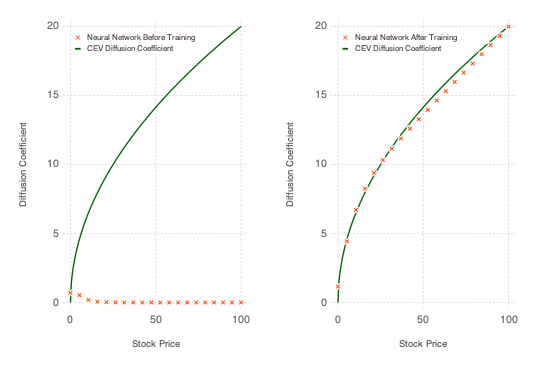

In [19]:
# Diffusion training
layer4 = layer(x=X_Training, y=Y_Training, Geom.line,Theme(line_width = 1pt,default_color=colorant"#006400"))
layer5 = layer(x=X_Testing, y=before_data,Geom.point,shape=[Gadfly.Shape.xcross],Theme(point_size =2.5pt,line_width = 1pt,default_color=colorant"#FF4500"))
p3 = Gadfly.plot(layer5,layer4,Theme(key_label_font_size=6pt,major_label_font_size=7pt),Guide.ylabel("Diffusion Coefficient"), Guide.xlabel("Stock Price"),Guide.manual_color_key("", ["Neural Network Before Training","CEV Diffusion Coefficient"],["#FF6347","#006400"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.xcross,Gadfly.Shape.hline]))


layer6 = layer(x=X_Testing, y= after_data,Geom.point,shape=[Gadfly.Shape.xcross],Theme(point_size =2.5pt,line_width = 1pt,default_color=colorant"#FF4500"))
p4 = Gadfly.plot(layer6,layer4,Guide.yticks(ticks = [ 0 5 10 15 20 ]),Theme(key_label_font_size=6pt,major_label_font_size=7pt),Guide.ylabel("Diffusion Coefficient"), Guide.xlabel("Stock Price"),Guide.manual_color_key("", ["Neural Network After Training","CEV Diffusion Coefficient"],["#FF6347","#006400"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.xcross,Gadfly.Shape.hline]))
plt = hstack(p3,p4)
#draw(PDF("myplot12.pdf", 14cm, 7cm), plt)

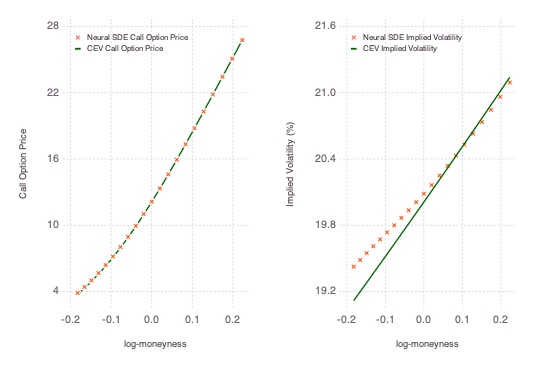

In [20]:
# Plotting call prices
NSDE_Call_Prices = NSDE_Price1[1,:];
CEV_Call_Prices = CEV_Price;
NSDE_Call_Vol = Vol_After1[1,:].*100;
CEV_Call_Vol = CEV_Vol[1,:].*100;

layer7 = layer(x= log_moneyness, y=NSDE_Call_Prices,Geom.point,shape=[Gadfly.Shape.xcross],Theme(point_size =2.5pt,default_color=colorant"#FF4500"))
layer8 = layer(x=log_moneyness, y=CEV_Call_Prices,Geom.line,Theme(line_width = 1pt,default_color=colorant"#006400"))
p5 = Gadfly.plot(layer7,layer8,Guide.yticks(ticks = [ 4    10    16    22    28]),Theme(key_label_font_size=6pt,major_label_font_size=7pt),Guide.ylabel("Call Option Price"), Guide.xlabel("log-moneyness"),Guide.manual_color_key("", ["Neural SDE Call Option Price","CEV Call Option Price"],["#FF6347","#006400"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.xcross, Gadfly.Shape.hline]),Coord.cartesian(xmin=-0.2, xmax=0.22, ymin=3, ymax=28))


layer9 = layer(x=log_moneyness, y= NSDE_Call_Vol,Geom.point, shape=[Gadfly.Shape.xcross],Theme(point_size =2.5pt,default_color=colorant"#FF4500"))
layer8 = layer(x=log_moneyness, y=CEV_Call_Vol, Geom.line,Theme(line_width = 1pt,default_color=colorant"#006400"))
p6 = Gadfly.plot(layer8,layer9,Guide.yticks(ticks = [19.20   19.80   20.40 21.00   21.60]),Theme(key_label_font_size=6pt,major_label_font_size=7pt),Guide.ylabel("Implied Volatility (%)"), Guide.xlabel("log-moneyness"),Guide.manual_color_key("", ["Neural SDE Implied Volatility","CEV Implied Volatility"],["#FF6347","#006400"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.xcross, Gadfly.Shape.hline]),Coord.cartesian(xmin=-0.2, xmax=0.22, ymin=19.1, ymax=21.6))#draw(PDF("myplot20.pdf", 14cm, 7cm), plt)
plt = hstack(p5,p6)
#draw(PDF("myplot13.pdf", 14cm, 7cm), plt)